# 以Restnet進行 CIFAR-10分類 

## 1. 資料載入及前處理

#### 使用torchvision 載入資料

In [1]:
import torch
from torch import  nn
# import torch as t
from torch.nn import  functional as F
import torchvision 
from torchvision import datasets, transforms 
from torchvision.transforms import ToPILImage
show = ToPILImage() # 把Tensor轉成Image，方便視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 檢查系統與軟體版本
print(torch.__version__)
!python -V
# !uname  -srvm
# !lscpu  | grep "Model name:" # 檢查CPU資訊
# !nvidia-smi # 檢查GPU資訊

1.4.0
Python 3.6.10


torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。  
> 邊的正規化是在torch tensor上操作，torch tensor基本上在函數內已經將影像8 bits值域(0–255)除上255，所以輸出為0–1之間。 所以平均數和標準差的設定通常都是0.xx


關於dataset與dataloader:
- 未來自行準備資料集時，由於各資料整理出的格式可能不同，需要繼承dataset的class類別自行定義修改、使資料output符合dataloader 格式    

### TRANSFORMS　資料轉換　　


In [12]:
# 定義對資料的預處理 

# 採用CIFAR10資料集RGB的mean與std 
mean = [0.4913991, 0.48215872, 0.44653144]
std  = [0.24703234, 0.24348538, 0.2615878]

# 將訓練資料集做各種資料增強 
train_transform = transforms.Compose(
   [transforms.RandomPerspective(distortion_scale=0.1), #　改變透視扭曲程度
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), #　改變色彩
    transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)), #　變焦、改變剪切角度
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])   # 轉為常態分佈標準化

# 驗證與測試資料集使用。僅正規化處理
test_transform = transforms.Compose(
    [transforms.ToTensor(),             # 轉為Tensor
     transforms.Normalize(mean, std)])   # 轉為常態分佈標準化

In [13]:
# 參數設定
root='./data'
batch_size = 50     # how many samples per batch to load
num_workers = 10    # number of subprocesses to use for data loading，0代表不使用
pin_memory = True   # whether to copy tensors into CUDA pinned memory. Set it to True if using GPU 
drop_last=True      
# torch.manual_seed(0) # 固定亂數種子
valid_size = 0.2

#### 切分torchvision中的訓練與驗證資料後，分別套用資料轉型
* 參考資料:  
[Train, Validation and Test Split for torchvision Datasets](https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb)

#### 指定索引，切分訓練與驗證資料

In [14]:
from torch.utils.data.sampler import SubsetRandomSampler

# 載入資料，注意訓練與驗證資料集視套用不同轉型方式
train_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform = train_transform)  # 50,000
valid_dataset = datasets.CIFAR10(root=root, train=True, download=True, transform = test_transform)   # 50,000

# 決定資料拆分大小
num_train = len(train_dataset)                 # 訓練集大小： 50,000
indices = list(range(num_train))               # 索引：1-50,000
split = int(np.floor(valid_size * num_train))  # 切分長度(驗證資料集大小)：10,000

# 隨機洗牌
np.random.seed(10)          # 設定隨機種子
np.random.shuffle(indices)  # 將索引洗牌

# 使用SubsetRandomSampler隨機抽樣索引，返回可迭代的物件
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)  # 訓練集的索引，內含40,000個數字
valid_sampler = SubsetRandomSampler(valid_idx)  # 驗證集的索引，內含10,000個數字

# 利用 torch.utils.data.DataLoader 數據加載器，將打包好的數據可以迭代進模型中訓練
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False,    # 有手動指定sampler時，要關掉隨機洗牌功能
    num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, sampler=valid_sampler, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
# 測試資料集
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform= test_transform)    # 10,000
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=pin_memory, drop_last=drop_last)

# torchvision.datasets.CIFAR10.classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('='*30)
# 檢視資料數據加載器資料形狀，每筆迭代出來的數量即送入的batch_size大小
images,labels=next(iter(train_loader))
print('Train data set:', images.shape, '; iter_size:',len(train_loader)) # (batch_size, channel, w, h)
images,labels=next(iter(valid_loader))
print('Valid data set:', images.shape, '; iter_size:',len(valid_loader))

Files already downloaded and verified
Train data set: torch.Size([50, 3, 32, 32]) ; iter_size: 800
Valid data set: torch.Size([50, 3, 32, 32]) ; iter_size: 200


### 資料視覺化

In [7]:
# (data, label) = valid_set[100]
# print(classes[label])

# # 因為 train_loader 中的資料已經是normalize過的，所以在畫出來前要先 denormalize。
# # ((data+1)/2) 是為了還原被標準化的資料 
# show((data+1)/2).resize((100,100))


In [8]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 输出图像的函数
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # 随机获取训练图片
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # 显示图片
# imshow(torchvision.utils.make_grid(images[:8]))
# # 打印图片标签
# print(' '.join('%5s,' % classes[labels[j]] for j in range(8)))

## 2. 定義神經網路(CNN)

### 載入預先訓練好的模型

In [17]:
from torchvision import models
model = models.resnet18(pretrained=True, progress=True)

# 載入後再手動更改想客製化的層，這些被更改的層，權重就需要自行訓練了
stride=(1, 1)
kernel_size=(3, 3)
padding=(1, 1)
model.conv1 = torch.nn.Conv2d(3, 64,
                              kernel_size = kernel_size, 
                              stride = stride,
                              padding = padding, bias=False )
# 預測為1000的輸出，改為10個
model.fc = torch.nn.Linear(in_features=512 , out_features=10)

In [35]:
# from torchsummary import summary
# summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [10]:
# kenel、output、padding size換算
# i=32; o=32; s=1; f=7 

# # o = ((i + 2*p-f)/s +1)
# p = ((o-1)*s + f- i)/2 
# print(p)


### 將模型移至GPU
* 先將模型指定至GPU，之後在執行訓練時也須配合將資料放入同一GPU 
* 最好明確指定GPU位置

In [11]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)
# model.to(device)

In [18]:
# torch.cuda.set_device(0)  # 設定要將cuda放置到哪一片gpu
model.cuda()          # 注意，對module 而言 .cuda()不是inplace操作，需要變數去承接
torch.cuda.current_device() # 檢查目cuda前所在的gpu

0

## 运行模型
檢視输入和输出张量的大小

In [13]:
#  for _, data in enumerate(trainloader, 0):
#     input = data.to(device)
#     output = model(input)
#     print("Outside: input size", input.size(),
#           "output_size", output.size())

## 3. 定義損失函數和最佳化器(Loss 、Optimizer)
使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）

關於learnibg rate 參數設定
- lr 在空的模型中來講算是上限，如果是使用別人以預先訓練好的可以選擇更小的lr值
- 可手動加入 adaptive lr 讓lr 在訓練過程後段變小、加速模型收斂。(但optimizer已經是設定adam了，理論上應該是變動式?)
- lr一開始設太大可能會衝過頭(超過區域/全域最小值的谷底)無法收斂

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.SGD(model.parameters(), lr = 1e-3 , momentum=0.9, weight_decay=1e-5)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 1e-05
)

## 4. 訓練模型
重複執行以下流程：
- 輸入資料
- 正向傳播+反向傳播
- 更新參數

In [ ]:
train_Loss_list = []
valid_Loss_list = []
train_Acc_list = []
valid_Acc_list = []
checkPoint_dic = {}

n_epoch = 30

for epoch in range(1, n_epoch + 1):  # loop over the dataset multiple times  

    train_loss = 0.0
    valid_loss = 0.0
    print('\nEpoch : ', epoch)

    ###################
    # train the model #
    ###################
    model.train()  # 明確指定model在訓練狀態(預設值)
    for i, data in enumerate(train_loader, 1): # i從1開始計數 
        n = len(train_loader)  #  len(train_loader)=遍歷一個epoch的次數
        
        # get the inputs 輸入資料
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda() # 把資料送入GPU(非inplace)
        #inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU，注意使用.to() 需要指定引數
        
        # clear the gradients of all optimized variables 梯度清空為0
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # calculate the batch loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # 更新參數
        optimizer.step()
        # update training loss
        train_loss += loss.item()  #如果是仅包含一个元素的tensor，可以使用.item()来得到对应的python数值
        

        # print statistics
        if i % n+1 == n :    # print every n mini-batches
            # 計算整體分類正確率
            accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size
            print(f'[epoch:{epoch:3d}, i:{i+1:4d}] train_loss: {train_loss/n:.3f}, train_accuracy:{accuracy:.3f}')

            train_Loss_list.append(train_loss / n )
            train_Acc_list.append(accuracy)
            train_loss = 0.0 # 每n回　loss 歸零重計


    ######################    
    # validate the model #
    ######################
    model.eval() # 啟動評估模式
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 1): # i從1開始計數 
            n = len(valid_loader)   #  len(valid_loader)=遍歷一個epoch的次數
        
            # get the inputs 輸入資料
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda() # 把資料送入GPU(非inplace)

            # zero the parameter gradients 梯度清空為0
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # calculate the batch loss
            loss = criterion(outputs, labels)
            # update training loss
            valid_loss += loss.item()

            # print statistics
        
            if i % n+1 == n :    # print every n mini-batches
                # 計算整體分類正確率
                accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size
        
                print(f'[epoch:{epoch:3d}, i:{i+1:4d}] valid_loss: {valid_loss/n:.3f}, valid__accuracy:{accuracy:.3f}')

                valid_Loss_list.append(valid_loss / n )
                valid_Acc_list.append(accuracy)
                valid_loss = 0.0 # 每n回　loss 歸零重計

    # best model
#     # 加入前幾個model參數的暫存
#     if if np.mean(valid_Acc_list[-2]) > np.mean(valid_Acc_list[-1]):
#         checkPoint_dic.update({f'epoch_{epoch}': {f'model_{epoch}': model.state_dict(),
#                                                   f'optimizer_{epoch}': optimizer.state_dict(),
#                                                   f'valid__accuracy_{epoch}': valid_Acc_list[-1]} 
#                               })
    
    
    # early stopping
    if epoch>6:
        if np.mean(valid_Loss_list[-6:-3]) < np.mean(valid_Loss_list[-3:]): break
        else:
            pass
        
                
print('Finished Training')


Epoch :  1
[epoch:  1, i: 800] train_loss: 2.658, train_accuracy:0.120
[epoch:  1, i: 200] valid_loss: 2.695, valid__accuracy:0.120

Epoch :  2
[epoch:  2, i: 800] train_loss: 2.662, train_accuracy:0.060
[epoch:  2, i: 200] valid_loss: 2.721, valid__accuracy:0.120

Epoch :  3


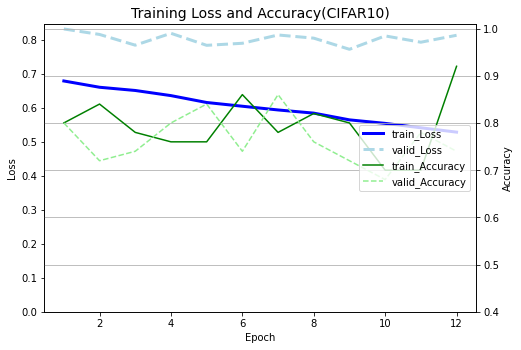

In [51]:
# 作圖
title_name = 'Training Loss and Accuracy(CIFAR10)'

train_Loss, valid_Loss = train_Loss_list, valid_Loss_list
train_Accuracy, valid_Accuracy = train_Acc_list, valid_Acc_list
x = range(1, epoch+1 )

# fig = plt.figure()
# fig, ax1, ax2 = plt.subplots()
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])
ax2 = ax1.twinx()

ax1.plot(x, train_Loss, label='train_Loss', color='blue', linewidth=3)
ax1.plot(x, valid_Loss, label='valid_Loss', color='lightblue', linewidth=3, linestyle='--'  )
ax2.plot(x, train_Accuracy, label='train_Accuracy', color='green')
ax2.plot(x, valid_Accuracy, label='valid_Accuracy', color='lightgreen',linestyle='--' )
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss'),ax1.set_ylim(0, )
ax2.set_ylabel('Accuracy'),ax2.set_ylim(0.4, 1.01)
ax2.grid(True)
plt.title(title_name, {'fontsize':14})
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 0.8))

fig.show()
# plt.close() 

# 圖片存檔
import sys,os,time
if not os.path.isdir('figure'):
           os.mkdir('figure')
time = time.strftime("%y%m%d_%H%M") # 檔名結尾加入目前時間 return yymmyy_hhtt
fig.savefig(f'./figure/{title_name}-{time}.png', bbox_inches='tight')



### 儲存訓練完的模型


#### 檢查點(Checkpoint)儲存

In [33]:
import os,time
if not os.path.isdir('checkpoint'):
           os.mkdir('checkpoint')
def save_checkpoint():
    PATH = f'./checkpoint/cifar_ResNet18_(pretrained,k=3,s=1)_epoch{epoch}.pth'
    # torch.save(model.state_dict(), PATH)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_Loss': train_Loss_list, 'valid_Loss': valid_Loss_list,
        'train_Accuracy': train_Acc_list, 'valid_Accuracy': valid_Acc_list},
        PATH)
# save_checkpoint()

## 5. 使用測試數據驗證結果

通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下

In [24]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 输出图片
(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


### 載入保存的模型

In [25]:
# model = models.resnet18(num_classes=10)
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### 以檢查點(Checkpoint)方式載入

In [44]:
# 定義模型 
# model = models.resnet50(num_classes=10) 需要先指定model類別， 

#定義優化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # 指定損失函數類別
optimizer = optim.SGD(model.parameters(), lr = 1e-5 , momentum=0.9, weight_decay=1e-5)  # 注意參數的設置，學習階段後期可調降學習速率

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_Loss,valid_loss = checkpoint['train_Loss'],checkpoint['valid_Loss'],
train_Accuracy,valid_Accuracy = checkpoint['train_Accuracy'],checkpoint['valid_Accuracy'],

In [26]:
# outputs = model(images)
# outputs.shape

#### 檢視模型判定的結果

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [27]:
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

神經網路在整個數據集上的表現

In [48]:
model.cuda()
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # 計算圖片在每個類別上的分數
        outputs = model(images)
        # 得分最高的那個類別
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


In [49]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        
        _, predicted = torch.max(outputs, dim=1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92 %
Accuracy of   car : 92 %
Accuracy of  bird : 85 %
Accuracy of   cat : 79 %
Accuracy of  deer : 89 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %


## 檢視測試資料集的預測結果

In [6]:
import PIL.ImageOps
import requests
from PIL import Image

# url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT76mSMtKQWGstcqGi-0kPWJyVBqz8RCp8SuplMipkidRY0z9Mc&usqp=CAU'
# response = requests.get(url, stream = True)
# img = Image.open(response.raw)
# plt.imshow(img)

In [7]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

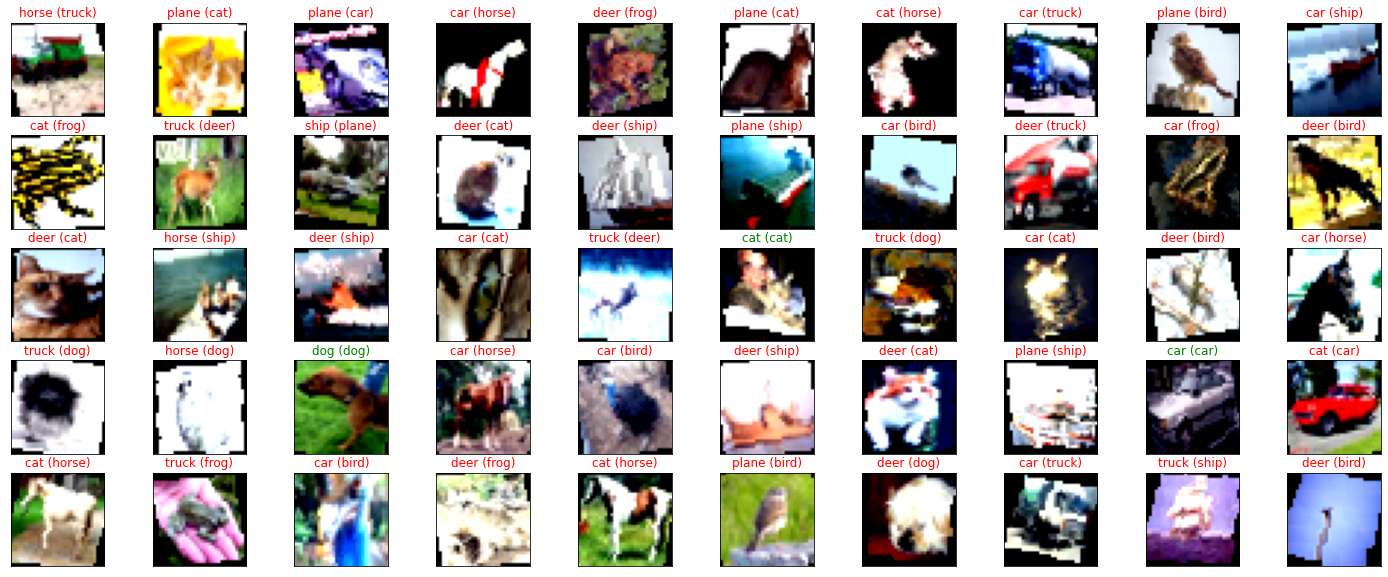

In [11]:
model.cuda()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 10))

for idx in np.arange(50):
  ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

